#  Visual English

###  Eryk Wdowiak

This notebook attempts to illustrate the English text that we're using to develop a neural machine translator.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.collocations import *

# import string
# import re

from wordcloud import WordCloud

In [3]:
import mxnet as mx
from mxnet import gluon
from mxnet import nd
import gluonnlp as nlp

from data import transform_data_word2vec, preprocess_dataset
from model import SG, CBOW
from utils import print_time

context = mx.cpu()

In [4]:
##  I thought this function would do far more than just run NLTK tokenizer.
##  We'll leave it in place.  It keeps our options open.
def process_line(line):
    tokens = word_tokenize(line)
    return tokens

In [5]:
##  read in the lemmatized data
df = pd.read_csv('dataset/train-mparamu_v2-lemmatized.en',header=None)
df.columns = ['en_text']
# df.head()

###  frequencies

In [6]:
##  flatten data to count words
proc_eng = list(map(process_line, df.en_text))
flat_eng = [item for sublist in proc_eng for item in sublist]
freq_eng = FreqDist(flat_eng)

In [7]:
freq_eng.most_common(20)

[('one', 912),
 ('sicilian', 854),
 ('want', 704),
 ('make', 583),
 ('go', 582),
 ('know', 571),
 ('say', 504),
 ('see', 470),
 ('sicily', 457),
 ('like', 453),
 ('time', 424),
 ('come', 419),
 ('give', 401),
 ('take', 394),
 ('good', 352),
 ('two', 349),
 ('would', 347),
 ('man', 325),
 ('donot', 321),
 ('work', 317)]

### counts

In [8]:
# create counts
eng_bar_words = [x[0] for x in freq_eng.most_common(25)]
eng_bar_counts = [x[1] for x in freq_eng.most_common(25)]

# put data into dictionary
eng_dict = dict(zip(eng_bar_words, eng_bar_counts))

In [9]:
# set the color of our bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))

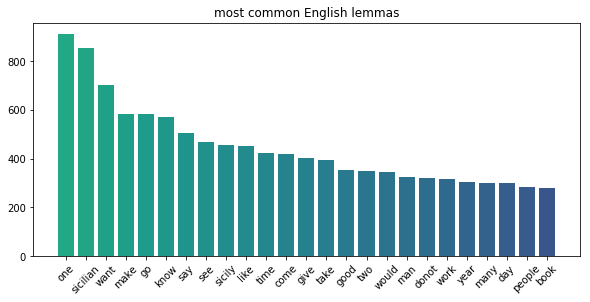

In [10]:
fig, axs = plt.subplots(figsize=(8,4))

axs.bar(eng_bar_words, eng_bar_counts , color=color)
axs.title.set_text('most common English lemmas')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

plt.tight_layout(pad=0)

plt.savefig('wb-en_lemmas.png')
plt.show()

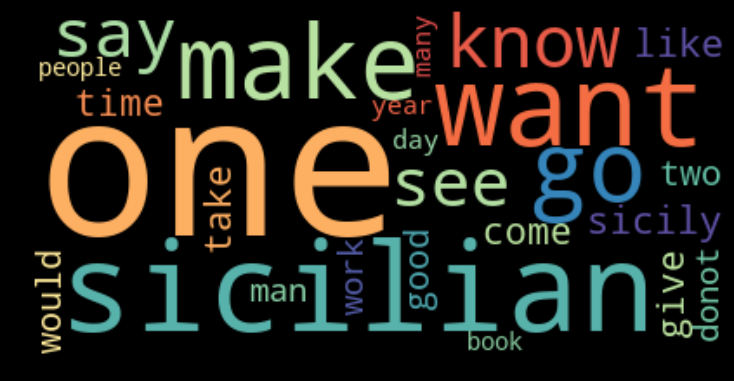

In [11]:
# create cloud of Sicilian words by frequency
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(eng_dict)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.savefig('wb-en_lemma-cloud.png')
plt.show()

### make wordcloud from embeddings

In [12]:
##  load datafile (so that we can retrieve vocabulary)
datafile = 'dataset/train-mparamu_v3-lemmatized.en.tsv'

##  CBOW model
model = CBOW
parmfile = './logs/en-cbow-r4-e01.params'
fname_insert = 'cbow'

##  skipgram model
# model = SG
# parmfile = './logs/en-skip-r2-e24.params'
# fname_insert = 'skip'

##  both trained with hyperparameters:
output_dim = 300
batch_size = 128

In [13]:
##  load the data
data = nlp.data.TSVDataset(datafile)
data, vocab, idx_to_counts = preprocess_dataset( data ) 

##  load the model
embedding = model(token_to_idx=vocab.token_to_idx, output_dim=output_dim,
                  batch_size=batch_size, #num_negatives=num_negatives,
                  negatives_weights=mx.nd.array(idx_to_counts))
embedding.load_parameters(parmfile)

##  get the word vectors
wvecs = embedding.embedding_out.weight.data()

##  count words with at least "min_words" appearances
min_words = 10
num_over_min = len( np.array(idx_to_counts)[ np.array(idx_to_counts)>= min_words ] )

print('vocabulary length:    ' + str(len(vocab)))
print('lemmas over ' + str(min_words) + ' times: ' + str(num_over_min))

vocabulary length:    2947
lemmas over 10 times: 1675


In [14]:
##  pairwise cosine similarity
def cos_sim(wordx, wordy):
    xx = wvecs[vocab.token_to_idx[wordx],]
    yy = wvecs[vocab.token_to_idx[wordy],]
    return nd.dot(xx, yy) / (nd.norm(xx) * nd.norm(yy))

##  full matrix of cosine similarity
def cos_mat( vecs ):
    ##  dot product divided by the norms
    xtx = nd.dot( vecs , vecs.T)
    nmx = nd.sqrt( nd.diag(xtx) ).reshape((-1,1))
    cnm = nd.dot( nmx , nmx.T )
    return xtx / cnm

In [15]:
##  create "WC Dict" ("word-to-cosine dictionary") for wordcloud
def mk_wcdict(word,k_words):
    
    ##  where to start?  first two tokens are: <BOS> <EOS>
    sv_start = 2
    
    ##  get cosine matrix
    cosmat = cos_mat( wvecs[sv_start:-1,] )
    
    ##  get the row of cosines
    idx_to_lookup = vocab.token_to_idx[word] - sv_start
    row_looked_up = cosmat[idx_to_lookup,]
    
    ##  nearest neighbors by cosine similarity
    knn_cosmat = row_looked_up.argsort()[::-1][1:k_words+1].astype(int).asnumpy()
    
    ##  indexes of nearest neighbors in vocab list
    knn_vocab_idx = list(knn_cosmat + sv_start)
    
    ##  get the words and cosine measures
    knn_vocab_words = [vocab.idx_to_token[idx] for idx in knn_vocab_idx]
    knn_vocab_cosines = [cosmat[idx_to_lookup,idx].asnumpy()[0] for idx in knn_cosmat]
        
    ##  return the dictionary for wordcloud
    return dict(zip(knn_vocab_words,knn_vocab_cosines))

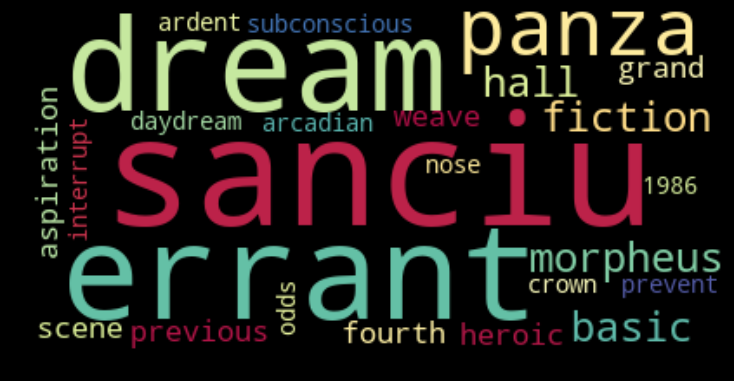

In [16]:
# create a cloud of 25 words for Don Chisciotti!
knn_wc_dict = mk_wcdict('chisciotti',25)
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(knn_wc_dict)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

fname = 'wc-en-' + fname_insert + '_chisciotti.png'
plt.savefig(fname)
plt.show()

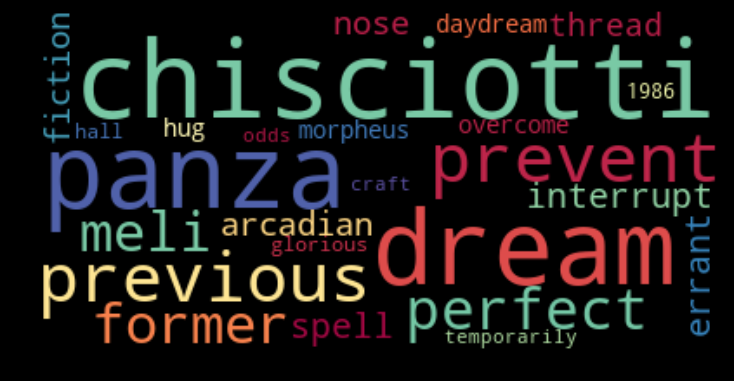

In [17]:
# create a cloud of 25 words for Sanciu Panza!
knn_wc_dict = mk_wcdict('sanciu',25)
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(knn_wc_dict)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

fname = 'wc-en-' + fname_insert + '_sanciu.png'
plt.savefig(fname)
plt.show()

### bigrams and trigrams

In [18]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()

In [19]:
eng_bi_finder = BigramCollocationFinder.from_words(flat_eng)
# eng_bi_finder.apply_freq_filter(5)
eng_bi_scored = eng_bi_finder.score_ngrams(bigram_measures.raw_freq)
eng_bi_scored[:10]

[(('arba', 'sicula'), 0.0009988328245645539),
 (('yes', 'want'), 0.000662147602801221),
 (('donot', 'know'), 0.0005835877177231101),
 (('learn', 'sicilian'), 0.0005611420362722213),
 (('speak', 'sicilian'), 0.0005499191955467767),
 (('donot', 'want'), 0.0005274735140958879),
 (('regional', 'assembly'), 0.0005274735140958879),
 (('italian', 'american'), 0.0005050278326449991),
 (('would', 'like'), 0.00047135931046866583),
 (('want', 'learn'), 0.0004601364697432214)]

In [20]:
eng_bi_pmi_finder = BigramCollocationFinder.from_words(flat_eng)
eng_bi_pmi_finder.apply_freq_filter(5)
eng_bi_pmi_scored = eng_bi_pmi_finder.score_ngrams(bigram_measures.pmi)
eng_bi_pmi_scored[0:10]

[(('delle', 'vigne'), 13.858240076575854),
 (('giardini', 'naxos'), 13.63584765523941),
 (('von', 'gloeden'), 13.635847655239406),
 (('pier', 'delle'), 13.595205670742061),
 (('abbey', 'thelema'), 13.180168171463215),
 (('sicilia', 'parra'), 13.12127448240965),
 (('donna', 'filumina'), 12.983770958659715),
 (('vittorio', 'emanuele'), 12.983770958659715),
 (('tony', 'demarco'), 12.742762859155919),
 (('fava', 'bean'), 12.732709194492)]

In [21]:
eng_tri_finder = TrigramCollocationFinder.from_words(flat_eng)
# eng_tri_finder.apply_freq_filter(5)
eng_tri_scored = eng_tri_finder.score_ngrams(trigram_measures.raw_freq)
eng_tri_scored[:10]

[(('want', 'learn', 'sicilian'), 0.00026934817741066616),
 (('tomasi', 'di', 'lampedusa'), 0.0002244568145088885),
 (('want', 'speak', 'sicilian'), 0.00014589692943077753),
 (('learn', 'sicilian', 'want'), 0.00013467408870533308),
 (('member', 'arba', 'sicula'), 0.00013467408870533308),
 (('english', 'yes', 'want'), 0.00011222840725444425),
 (('sicilian', 'yes', 'want'), 0.00011222840725444425),
 (('would', 'like', 'go'), 0.00011222840725444425),
 (('giuseppe', 'tomasi', 'di'), 0.00010100556652899982),
 (('sicilian', 'want', 'learn'), 0.00010100556652899982)]

In [22]:
eng_tri_pmi_finder = TrigramCollocationFinder.from_words(flat_eng)
eng_tri_pmi_finder.apply_freq_filter(5)
eng_tri_pmi_scored = eng_tri_pmi_finder.score_ngrams(trigram_measures.pmi)
eng_tri_pmi_scored[0:10]

[(('pier', 'delle', 'vigne'), 27.71648015315171),
 (('tour', 'de', 'france'), 23.337968529897978),
 (('rosina', 'san', 'paolo'), 23.098502595202596),
 (('tomasi', 'di', 'lampedusa'), 22.362843198537014),
 (('via', 'rom', 'excuse'), 22.27497044251168),
 (('review', 'nino', 'provenzano'), 21.991587391286085),
 (('chisciotti', 'sanciu', 'panza'), 20.946679033803882),
 (('giuseppe', 'tomasi', 'di'), 20.119692217033766),
 (('rom', 'excuse', 'tell'), 18.98956822364943),
 (('election', 'regional', 'assembly'), 18.340475385508554)]